# **Number detection algorithm**

## **Image Traitement**

Before using the ML algorithm it must verify that the images that will be used in the classification is in the same format and size as the ones in the database (MNIST)

In [1]:
import os
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import pandas as pd

from keras.datasets import mnist
from sklearn import svm
from sklearn.metrics import accuracy_score
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import RandomizedSearchCV
from sklearn.grid_search import GridSearchCV
from sklearn.externals import joblib

import generateDataset as db

Using TensorFlow backend.


# Read database

Functions used to read the database (train and test) from MNIST and also from the csv file generated with the images captured from the pico camera

In [2]:
def separate_array(data):    
    image = []
    labels = []
    for line in data:
        image.append(np.array(line[:-1]))
        labels.append(line[-1])
    
    return image, labels

In [3]:
X_train, Y_train = separate_array(np.load('./train_classes.npy'))

In [4]:
X_validation, Y_validation = separate_array(np.load('./validation_classes.npy'))

# **Evaluation methods**

This part contains the functions used to analyse the accuracy of the classifier

In [5]:
def plot_confusion_matrix(clf, data_x, data_y):
    classes = range(1,7)
    
    Ypred = clf.predict(data_x)
    
    # Computation of confusion matrix on testing set
    cm = confusion_matrix(data_y, Ypred)
    
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# **Support Vector Machine algorithm**

In [6]:
def create_number_list(data):
    images = []
    for x in data:
        images.append(x.reshape(-1))

    return images

In [7]:
def train_svmModel():
    # Train on the first N train images
    train_x = create_number_list(X_train)
    train_y = np.array(Y_train)
    
    #Train the classifier
    clf =  svm.SVC(kernel='rbf')
    return clf.fit(train_x, train_y)


In [8]:
def visualize_svm_Model(clf, X_data, Y_data, filename, typeData):
    # Visualize on the images from dataset:
    data_x = create_number_list(X_data)
    data_y = Y_data 
    predicted = clf.predict(data_x)
    
    plot_confusion_matrix(clf, data_x, data_y)
    plt.title(typeData + ' confusion matrix: accuracy of ' + str(round((accuracy_score(data_y, predicted) * 100), 3)) + "% \n Used " + str(len(data_x)) + " images")
    plt.savefig(filename)

In [9]:
svm_classifier = train_svmModel()

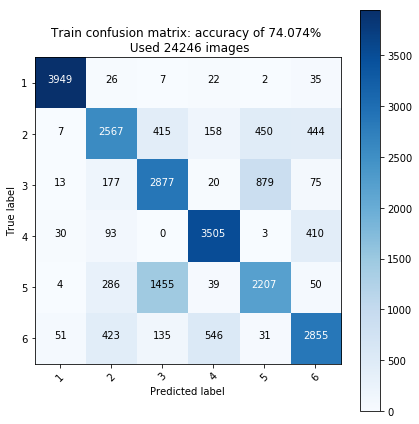

In [10]:
visualize_svm_Model(svm_classifier, X_train, Y_train,'./Results/svm/train', 'Train')

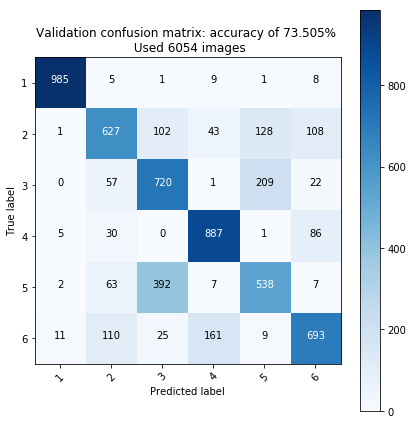

In [11]:
visualize_svm_Model(svm_classifier, X_validation, Y_validation,'./Results/svm/validation', 'Validation')

In [12]:
# save the classifier
filename = './Results/svm/svm_classifier.sav'
joblib.dump(svm_classifier, filename, compress = 3)  

['./Results/svm/svm_classifier.sav']

# **Multiple Hyperparameter Study**
This part consist in making a study of the hyperparameter of the classifier, using the gridsearch method from the scikitlearn library.

In [13]:
# Define the parameter values that should be searched
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]

# Specify "parameter grid"
grid_parameters = dict(C=Cs, gamma=gammas)

# Specify "parameter distributions" rather than a "parameter grid"
dist_parameters = dict(C=Cs, gamma=gammas)

# Since both parameters are discrete, so param_dist is the same as param_grid

# Finally define the classifier, in this case the KNN classifier
new_svm = svm.SVC(kernel='rbf')

In [14]:
# This block is done both grid and random search for the hyperparameters for N numbers
def compute_best_classifier(X_data, Y_data, param_grid, param_dist, model):
    grid_best_scores = []
    grid_best_params = []
    grid_best_estimator = []

    rand_best_scores = []
    rand_best_params = []
    rand_best_estimator = []

    train_x = create_number_list(X_data)
    train_y = np.array(Y_data)

    for i in list(range(0)):
        print("Iteration num: " + str(i))
        grid = GridSearchCV(model, param_grid, cv=10, scoring='accuracy', n_jobs = -1)
        grid.fit(train_x, train_y)
        grid_best_scores.append(grid.best_score_)
        grid_best_params.append(grid.best_params_)
        grid_best_estimator.append(grid.best_estimator_)

        rand = RandomizedSearchCV(model, param_dist, cv=10, scoring='accuracy', n_iter=10, n_jobs = -1)
        rand.fit(train_x, train_y)
        rand_best_scores.append(rand.best_score_)
        rand_best_params.append(rand.best_params_)
        rand_best_estimator.append(rand.best_estimator_)

    print("Finished searching the hyper parameters!")
    
    # This block draw accuracies of the differents classifiers used in the grid and random search

    plt.figure(figsize=(16, 8))
    plt.title("Final search results")   
    plt.plot(range(len(grid_best_scores)), grid_best_scores, label = 'Exaustive grid')
    plt.plot(range(len(rand_best_scores)), rand_best_scores, label = 'Random grid')
    plt.xlabel('Number of classifier')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xticks(range(len(grid_best_scores)))
    plt.savefig('./Results/knn/tuningParameters')
    #plt.show()

    print("GRID SEARCH RESULTS")
    print("The best accuracy is: " + str(np.max(grid_best_scores) * 100) + "%")
    print("The parameters is: " + str(grid_best_params[np.argmax(grid_best_scores)]))
    print('\n')
    print("RANDOMGRID SEARCH RESULTS")
    print("The best accuracy is: " + str(np.max(rand_best_scores) * 100) + "%")
    print("The parameters is: " + str(rand_best_params[np.argmax(rand_best_scores)]))

    return rand_best_estimator[np.argmax(rand_best_scores)]

In [22]:
dist_parameters

{'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]}

# BEST SVM + Photos Test

In [15]:
#Train the best classificator for a N sample of numbers
def train_best_classifier(X_data, Y_data, grid_par, dist_par, model):   
    classificator = compute_best_classifier(X_data, Y_data, grid_par, dist_par, model)

    return classificator.fit(X_data, Y_data)

In [ ]:
%%time 

best_svm_classifier = train_best_classifier(X_train, Y_train, grid_parameters, dist_parameters, new_svm)


In [ ]:
visualize_svm_Model(best_svm_classifier, X_validation, Y_validation,'./Results/svm/best_validation', 'Validation')

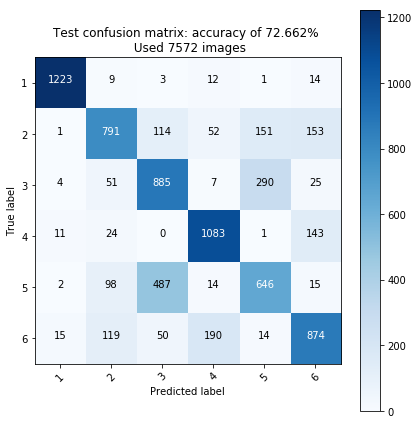

In [13]:
X_test, Y_test = separate_array(np.load('./test_classes.npy'))
visualize_svm_Model(svm_classifier, X_test, Y_test,'./Results/svm/test', 'Test')

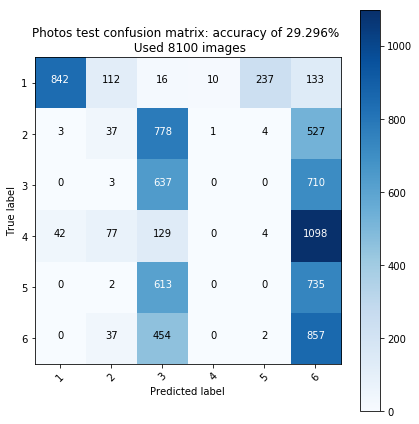

In [14]:
X_photos_test, Y_photos_test = separate_array(np.load('./test_photos_classes.npy'))
visualize_svm_Model(svm_classifier, X_photos_test, Y_photos_test,'./Results/svm/photos_test', 'Photos test')

In [ ]:
# save the classifier
filename = './Results/svm/best_svm_classifier.sav'
joblib.dump(best_svm_classifier, filename, compress = 3)  